# SpecAugment with TorchAudio
by [Zach Caceres](https://github.com/zcaceres) and [Jenny Cai](https://github.com/qcai2002)

This notebook feature a Pytorch implementation of the data augmentation techniques in [SpecAugment](https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html) by Google Brain.

The techniques are:
- Time Warp
- Frequency Mask
- Time Mask

SpecAugment reports that Frequency Mask and Time Mask were the most effective augmentations and less computationally expensive than Time Warp. We included Time Warp for completeness.

### Prerequisites
Be sure you've run `install.sh` before running this notebook!

### Setup

In [1]:
#Export
from collections import namedtuple
import random

import torch
import torchaudio
from torchaudio import transforms

This converts our implementation of `sparse_image_warp` into a Python file we can import.

In [2]:
%%sh
python notebook2script.py SparseImageWarp.ipynb

Converted SparseImageWarp.ipynb to nb_SparseImageWarp.py


In [3]:
from exp.nb_SparseImageWarp import sparse_image_warp

## Loading Audio

Let's check out our sample wav file (a snippet of background chatter from a party). We'll load it into a `namedtuple` to keep the signal & sample rate tied together.

In [4]:
from IPython.display import Audio

In [5]:
sample = './party-crowd.wav'

In [6]:
AudioData = namedtuple('AudioData', ['sig', 'sr'])

In [7]:
audio = AudioData(*torchaudio.load(sample))

In [8]:
audio

AudioData(sig=tensor([[-2.1362e-04,  2.4414e-04, -1.8311e-04,  ..., -2.2736e-02,
         -5.7678e-03,  1.5350e-02],
        [-3.0518e-05, -3.0518e-05,  6.1035e-05,  ..., -1.9193e-01,
         -1.9287e-01, -2.0126e-01]]), sr=44100)

In [9]:
def check_audio(aud):
    display(Audio(data=aud.sig, rate=aud.sr))

In [10]:
check_audio(audio)

## Wav to (Mel)Spectrogram

Simple wrapper for `torchaudio`'s transforms to make a decibel-scale Melspectrogram. Borrowed from [fastai-audio](https://github.com/zcaceres/fastai-audio), with some tweaks.

In [11]:
def tfm_spectro(ad:Audio, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.
    mel = transforms.MelSpectrogram(sr=ad.sr, n_mels=n_mels, n_fft=n_fft, ws=ws, hop=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(ad.sig.reshape(1, -1))
    mel = mel.permute(0,2,1) # swap dimension, mostly to look sane to a human.
    if to_db_scale: mel = transforms.SpectrogramToDB(stype='magnitude', top_db=f_max)(mel)
    return mel

In [12]:
spectro = tfm_spectro(audio, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)

In [13]:
# # Run this cell if you want to use your spectrogram to run the SparseImageWarp notebook.
# %store spectro

## Viewing a spectrogram

In [14]:
import matplotlib.pyplot as plt

In [15]:
def tensor_to_img(spectrogram):
    plt.figure(figsize=(14,1)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show();
    display(spectrogram.shape)

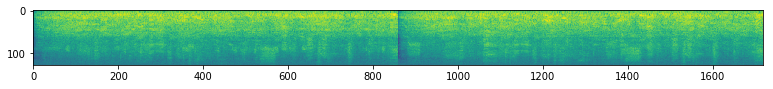

torch.Size([1, 128, 1718])

In [16]:
tensor_to_img(spectro)

## Time Warp

Time Warp is described as:
> Time warping is applied via the function sparse image warp of tensorflow. Given a log mel spectrogram with τ time steps, we view it as an image where the time axis is horizontal and the frequency axis is vertical. A random point along the horizontal line passing through the center of the image within the time steps (W, τ − W) is to be warped either to the left or right by a distance w chosen from a uniform distribution from 0 to the time warp parameter W along that line.

Intuitively we squish/stretch the audio in a given direction bounded by the `W` parameter we select.

NOTE:
`sparse_image_warp` does not exist in Pytorch, so you can see our implementation in the SparseImageWarp.ipynb notebook. Our implementation skips certain features like add clamping.

You should be careful with your `W` parameter because it's highly dependent on your audio and spectrogram. 

*Sanity check your spectrograms if you're using this transform.*

In [17]:
#Export
def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    device = spec.device
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = (torch.tensor([[[y, point_to_warp]]], device=device), 
                         torch.tensor([[[y, point_to_warp + dist_to_warp]]], device=device))
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

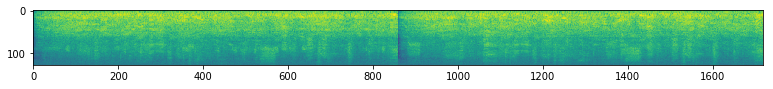

torch.Size([1, 128, 1718])

/home/jupyter/git/spec_augment/exp/nb_SparseImageWarp.py:300: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)


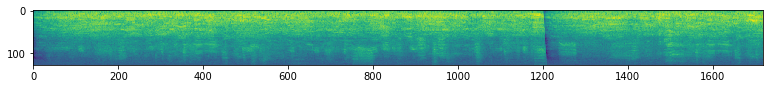

torch.Size([1, 128, 1718])

In [18]:
def test_time_warp():
    tensor_to_img(time_warp(spectro))
tensor_to_img(spectro)    
test_time_warp()

## Frequency Mask

Frequency masking is described as:
> Frequency masking is applied so that f consecutive mel
frequency channels [f0, f0 + f) are masked, where f is first chosen from a uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen from 0, ν − f). ν is the number of mel frequency channels.

Intuitively, this is similar to cutout in computer vision workflows. We mask certain frequency bands with either the mean value of the spectrogram or zero.

In [19]:
#Export
def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

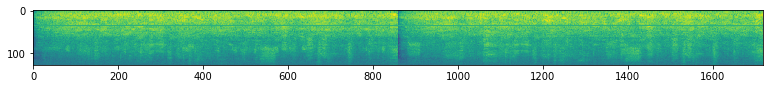

torch.Size([1, 128, 1718])

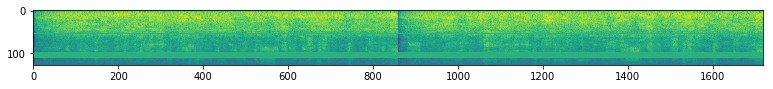

torch.Size([1, 128, 1718])

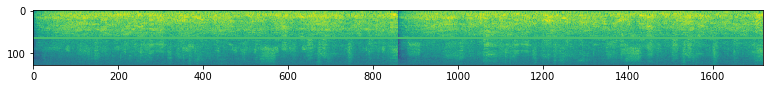

torch.Size([1, 128, 1718])

In [20]:
def test_freq_mask():
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spectro, num_masks=2, replace_with_zero=True))
test_freq_mask()

## Time Mask

Time masking is described as:
> Time masking is applied so that t consecutive time steps
[t0, t0 + t) are masked, where t is first chosen from a uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t). We introduce an upper bound on the time mask so that a time mask cannot be wider than p times the number of time steps.

Intuitively, this is similar to cutout and the frequency mask above. We mask certain time ranges with the mean value of the spectrogram or zero.

In [21]:
#Export
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

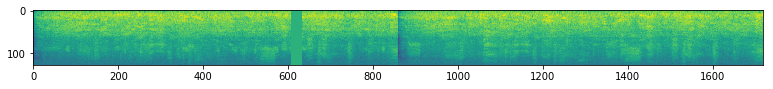

torch.Size([1, 128, 1718])

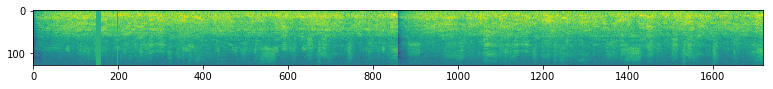

torch.Size([1, 128, 1718])

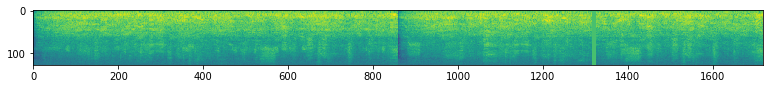

torch.Size([1, 128, 1718])

In [22]:
def test_time_mask():
    tensor_to_img(time_mask(spectro))
    # Two Masks...
    tensor_to_img(time_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spectro, num_masks=2, replace_with_zero=True))
test_time_mask()

## Combined
Here we combine all three transforms.

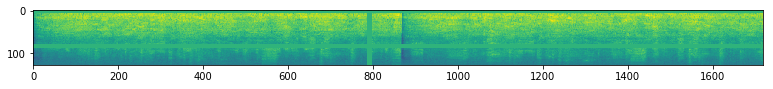

torch.Size([1, 128, 1718])

In [23]:
combined = time_mask(freq_mask(time_warp(spectro), num_masks=2), num_masks=2)
tensor_to_img(combined)

## Performance

### CPU

In [24]:
%%timeit -n 10
time_warp(spectro)

36 ms ± 325 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit -n 100
freq_mask(spectro)

143 µs ± 7.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit -n 100
time_mask(spectro)

133 µs ± 6.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%%timeit -n 10
time_mask(freq_mask(time_warp(spectro), num_masks=2), num_masks=2)

36.4 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### GPU

In [28]:
cspectro = spectro.cuda()

In [29]:
%%timeit -n 100
time_warp(cspectro)

4.97 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%%timeit -n 100
freq_mask(cspectro)

72.1 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%%timeit -n 100
time_mask(cspectro)

77.4 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%%timeit -n 100
time_mask(freq_mask(time_warp(cspectro), num_masks=2), num_masks=2)

4.65 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
